# ML Coding Challenge
## Random Forest Rangers
## Urban, Atilla, Jano

ssh -N -T -L 30001:localhost:30001 urban@dgx-2-02.ics.unisg.ch

## Setup

In [1]:
import os


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load Training & Test Data

In [2]:
# file locations
DATA_PATH = "drive/MyDrive/AIML24"
TRAINING_PATH = DATA_PATH + "/remote_sensing/otherDatasets/sentinel_2/tif"
TEST_PATH = DATA_PATH + "/remote_sensing/otherDatasets/sentinel_2/testset"

# mount g-drive
try:
    from google.colab import drive
    drive.mount('/content/drive')

    # copy files into runtime for performance
    !cp "drive/MyDrive/AIML24" "AIML24"
    DATA_PATH = "AIML24"
except:
    pass # probably local environment



In [3]:
# Download Training Data
# !wget https://madm.dfki.de/files/sentinel/EuroSATallBands.zip --no-check-certificate
# !unzip EuroSATallBands.zip
# !mv ds/* "drive/MyDrive/AIML24"

# ☝️Test data must be downloaded manually: put into AIML24/remote_sensing/otherDatasets/sentinel_2/testdata dir

In [4]:
# !unzip "drive/MyDrive/AIML24/remote_sensing/otherDatasets/sentinel_2/testset.zip"
# !mv testset/testset/* "drive/MyDrive/AIML24/remote_sensing/otherDatasets/sentinel_2/testset"

## Define PyTorch Dataset

In [5]:
import glob
len(glob.glob(os.path.join(TEST_PATH,  f"*.npy")))

4232

In [6]:
!pip install rasterio

DEPRECATION: bert-score 0.3.11 has a non-standard dependency specifier transformers>=3.0.0numpy. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of bert-score or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [7]:
import rasterio as rio
import glob
from torch.utils.data import Dataset
from collections.abc import Callable


def load_img(img_path:str) -> np.ndarray:
  if img_path.split('.')[-1] == "tif":
    with rio.open(img_path, "r") as d:
      img = d.read([1,2,3,4,5,6,7,8,9,10,11,12,13])
      # Assuming bands 2, 3, 4 are the RGB channels (1-based indexing in rasterio)
      # Adjust the indices as necessary based on your data
      # img = d.read([2, 3, 4])
      img = reshape_as_image(img)
  else:
    img = np.load(img_path)
  return img


ids2labels = {0: 'AnnualCrop',
 1: 'Forest',
 2: 'HerbaceousVegetation',
 3: 'Highway',
 4: 'Industrial',
 5: 'Pasture',
 6: 'PermanentCrop',
 7: 'Residential',
 8: 'River',
 9: 'SeaLake'}

labels2ids = {v: k for k, v in ids2labels.items()}

def text2oh(label):
    one_hot = np.zeros(10)
    one_hot.put(labels2ids[label], 1)
    return one_hot
    
def oh2text(one_hot):
    try:
        one_hot = one_hot.numpy()
    except:
        pass
    idx = np.argmax(one_hot)
    return ids2labels[idx]

class SentinelTrain(Dataset):
    def __init__(self, transformations=None):
        self.img_paths = [path.replace('\\', '/') for path in glob.glob(os.path.join(TRAINING_PATH, "*", f"*.tif"))]

        # labels = set([path.split('/')[-1].split('_')[0] for path in self.img_paths]) # get unique labels
        # self.label2ids = {name: id for (id, name) in enumerate(sorted(labels))} # map an id to each label
        # self.ids2label = {v:k for k, v in self.label2ids.items()} # reverse lookup dict
        self.transformations = transformations
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = load_img(img_path)
        
        if self.transformations:
            image = self.transformations(image)
        
        label = img_path.split("/")[-1].split("_")[0]
        one_hot = text2oh(label)
        return image, one_hot
    
    
    
def get_id(img_path):
    return img_path.split("/")[-1].split("_")[-1].split(".")[0]

class SentinelTest(Dataset):
    def __init__(self, transformations=None):
        self.img_paths = [path.replace("\\","/") for path in glob.glob(os.path.join(TEST_PATH,  f"*.npy"))]
        self.transformations = transformations
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = load_img(img_path)
        image_id = get_id(img_path)
        
        if self.transformations:
            image = self.transformations(image)
        return image, image_id
    

In [8]:
# !pip install torchvision

In [9]:
# Create instances of the Dataset Class for both train & test
import torch
import torchvision.transforms as transforms


def bandselect(img):
    return img[:, :, [3,2,1]]

def convert_to_float(img):
    return img.astype(np.float32) / 10000.0

def permute(img):
    return img.transpose(2, 0, 1)

# TODO: improvement -> find global max / min
def l2a_approx(img):
    l2a_bands = img[:,:,[0,1,2,3,4,5,6,7,8,9,11,12]]
    band_min = np.min(l2a_bands, (0,1)) # minimal value per band
    return l2a_bands - band_min # dark object subtraction algo approximation

# Define the transformation functions as lambdas or wrap in Lambda transform
train_transforms = transforms.Compose([
   l2a_approx,
    # bandselect,
    convert_to_float,
    permute
])
train_dataset = SentinelTrain(train_transforms)


test_transforms  = transforms.Compose([
    # bandselect,
    convert_to_float,
    permute
])
test_dataset = SentinelTest(test_transforms)

print(len(train_dataset))
print(len(test_dataset))

27000
4232


In [10]:
from torch.utils.data import random_split



In [12]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import numpy as np
import torch


train_dataset_subset, val_dataset_subset = random_split(train_dataset, [.8, .2])

train_dataloader = DataLoader(train_dataset_subset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset_subset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)



In [11]:
ids2labels

{0: 'AnnualCrop',
 1: 'Forest',
 2: 'HerbaceousVegetation',
 3: 'Highway',
 4: 'Industrial',
 5: 'Pasture',
 6: 'PermanentCrop',
 7: 'Residential',
 8: 'River',
 9: 'SeaLake'}

In [13]:
# Utility function to display image from dataset
from rasterio.plot import reshape_as_image

def normalize_for_display(band_data):
    """Normalize multi-spectral imagery across bands.
    The input is expected to be in HxWxC format, e.g. 64x64x13.
    To account for outliers (e.g. extremly high values due to
    reflective surfaces), we normalize with the 2- and 98-percentiles
    instead of minimum and maximum of each band.
    """
    band_data = np.array(band_data)
    lower_perc = np.percentile(band_data, 2, axis=(0,1))
    upper_perc = np.percentile(band_data, 98, axis=(0,1))
    print(lower_perc)
    print(upper_perc)
    return (band_data - lower_perc) / (upper_perc - lower_perc)


def print_image(img, label, rgb_bands=[3,2,1])-> None:
  """Displays an image. Indices of bands given by "rgb_bands" will be displayed as RGB in the print
  """
  img = img.transpose(1,2,0)
  img = normalize_for_display(img)
  img = img[:, :, rgb_bands]
  fig, ax = plt.subplots(1, figsize=(5,5))
  ax.imshow((img * 255).astype(np.uint8), vmin=0, vmax=255)
  # ax.imshow(img)
  ax.set_title(label)
  ax.axis(False)
  plt.tight_layout()

  plt.show()

[3.99999990e-04 6.88999994e-03 1.41000003e-02 8.09000023e-03
 5.70000010e-03 2.93400003e-02 3.70700002e-02 9.19700004e-02
 4.99999989e-03 9.99999975e-05 3.70000000e-03 5.53000011e-02]
[0.0191     0.048      0.0672     0.1164     0.1109     0.21391
 0.32223    0.39071001 0.03841    0.0004     0.13121    0.34502   ]


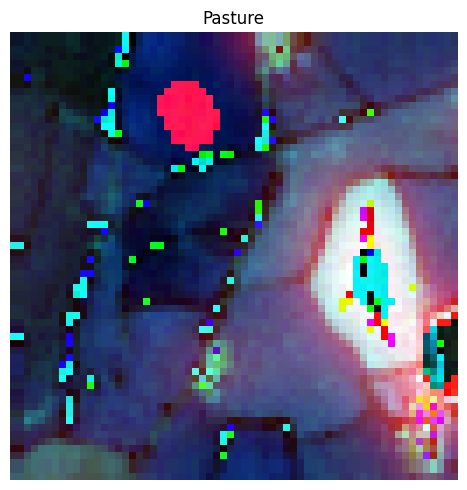

In [14]:
# Example image from train
img, label = train_dataset.__getitem__(120)
print_image(img, oh2text(label), [0,1,2])


In [15]:
oh2text(label)

'Pasture'

In [16]:
labels2ids

{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

In [17]:
train_dataset.img_paths[100]

'drive/MyDrive/AIML24/remote_sensing/otherDatasets/sentinel_2/tif/Pasture/Pasture_1763.tif'

[0.0248  0.0152  0.0166  0.0147  0.0189  0.017   0.0171  0.01269 0.017
 0.0159  0.0158  0.0144 ]
[0.027  0.0308 0.0321 0.0295 0.0241 0.022  0.022  0.0268 0.022  0.018
 0.0189 0.0175]


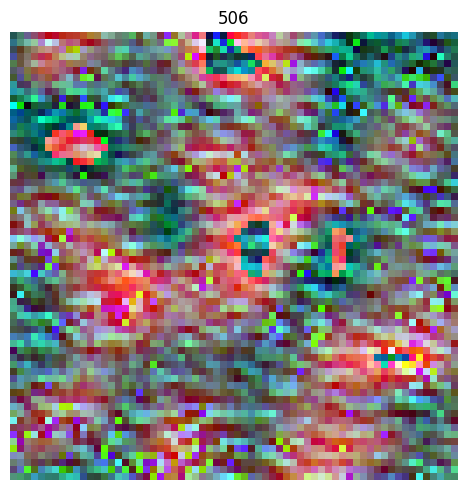

In [18]:
# example image from test
img, label = test_dataset.__getitem__(800)
print_image(img, label, [0,1,2])


## Training

In [23]:
img.shape[0]

12

In [20]:
import torchvision

torchvision.models.vit_b_16

<function torchvision.models.vision_transformer.vit_b_16(*, weights: Optional[torchvision.models.vision_transformer.ViT_B_16_Weights] = None, progress: bool = True, **kwargs: Any) -> torchvision.models.vision_transformer.VisionTransformer>

train model

In [57]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchsummary import torchsummary

def get_num_channels():
    img, _ = test_dataset.__getitem__(0)
    return img.shape[0]


class CustomResNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet, self).__init__()
        # Load a pre-trained ResNet model
        self.resnet = models.resnet18(pretrained=True)

        # Modify the first convolutional layer to accept 3 input channels
        self.resnet.conv1 = nn.Conv2d(get_num_channels(), 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        # self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), padding=(1, 1), bias=False)

        # Replace the final fully connected layer to match the number of classes
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet(x)


# Channel ViT https://github.com/insitro/ChannelViT

from channelvit.backbone.channel_vit import ChannelVisionTransformer

model = ChannelVisionTransformer(
        img_size=(12,64,64),
        patch_size=16,
        in_chans=12,
        num_classes=10,
        embed_dim=768,
        depth=12,
        num_heads=12,
        mlp_ratio=4.0,
        qkv_bias=False,
        qk_scale=None,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.0,
        norm_layer=nn.LayerNorm,
        
    )


# Number of classes in your dataset
# num_classes = 10

# Create an instance of the model
# model = CustomResNet(num_classes=num_classes)

# If you want to see the model summary for input size of 64x64 RGB images
# if torch.cuda.is_available():
#     model.cuda()
#     torchsummary.summary(model, (get_num_channels(), 64, 64))
# else:
#     torchsummary.summary(model, (get_num_channels(), 64, 64))

torch.Size([1, 768, 12, 1, 1])

training loop

In [58]:
import tqdm



# Init collection of training epoch losses
train_losses = []
train_epoch_losses = []

# Set the model in training mode
model.train()

num_epochs = 12
mini_batch_size = 64 # size of the mini-batches

cross_entropy = nn.CrossEntropyLoss()

from torch import optim
learning_rate = 0.002
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train for n epochs
for epoch in range(num_epochs):

    # Init collection of mini-batch losses
    train_mini_batch_losses = []

    train_loader_progress = tqdm.tqdm(train_dataloader)


    # Update for each min-batch
    for i, (x,y) in enumerate(train_loader_progress):
        # Transfer data to compute device
        x, y = torch.tensor(x).to(device), torch.tensor(y).to(device)

        # Forward pass
        #x = x.float()
        pred = model(x)

        # Reset model's gradients
        model.zero_grad()

        # Compute loss
        loss = cross_entropy(pred, y)

        # Run backward pass
        
        loss.backward()

        # Update network paramaters
        optimizer.step()

        # Store mini-batch losses
        train_mini_batch_losses.append(loss.data.item())
        train_losses.append(loss.data.item())

        train_loader_progress.set_description(f"Loss: {loss.item():0.5f}")

        #np.seterr(divide='ignore', invalid='ignore')

    # Compute epoch loss
    train_epoch_loss = np.mean(train_mini_batch_losses)
    train_epoch_losses.append(train_epoch_loss)

    print(f"Epoch {epoch} - Loss: {train_epoch_loss:0.5f}")

# Save final model
torch.save(model.state_dict(), "checkpoint.pt")

  0%|                                                                                                                                                                                                                                                                 | 0/338 [00:00<?, ?it/s]

/tmp/ipykernel_6088/1272816039.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = torch.tensor(x).to(device), torch.tensor(y).to(device)
  0%|                                                                                                                                                                                                                                                                 | 0/338 [00:00<?, ?it/s]


KeyError: 'channels'

[None]

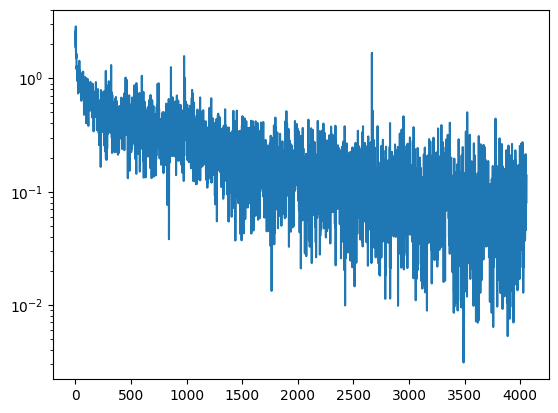

In [27]:
import seaborn as sns


p = sns.lineplot(train_losses)
p.set(yscale='log')

# Validation

In [29]:
# set model in evaluation mode
model.eval()


validate = []
for i, (imgs, labels) in enumerate(val_dataloader):
    preds = model(imgs.to("cuda"))
    pred_labels = [oh2text(oh.detach().cpu()) for oh in preds]
    validate += list(zip(labels, preds))


# TODO: Test Metrics

# Test

evaluation loop

In [ ]:
img_path = "drive/MyDrive/AIML24/remote_sensing/otherDatasets/sentinel_2/testset/test_3310.npy"

def get_id(img_path):
    return img_path.split("/")[-1].split("_")[-1].split(".")[0]

get_id(img_path)

'3310'

In [30]:
model.eval()

classArray = []

for i, (imgs, paths) in enumerate(test_dataloader):

    img_ids = [get_id(path) for path in paths]
    preds = model(imgs.to("cuda"))
    preds = list(preds.detach())
    preds = [oh2text(pred.detach().cpu()) for pred in preds]
    classArray += list(zip(img_ids, preds))


In [31]:
len(classArray)

4232

In [ ]:
# Ziel: Array: classArray von (image index, predicted label)

#loop durch test_dataloader (minibatch)
    # pred labels (alle im minibatch auf einmal)
    # find image ids for each pred ()
    # Translate pred to text label
    # append to array

## Submission





>We then create a csv with all our predictions to upload it to kaggle.

In [32]:
import csv

with open('submission_v1.csv', 'w', newline='') as csvfile:
    # Create a CSV writer object
    writer = csv.writer(csvfile)

    # Write the header row
    writer.writerow(['test_id', 'label'])

    # Write each string to a row with its corresponding index as the test_id
    for i, label in classArray:
        writer.writerow([i, label])